# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Name: Cody Lam

I understand that my submission needs to be my own work: yes

Points: 10


---



Complete this notebook and submit it (save/print as pdf). The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [ ]:
"""
- Intial State: The game will start with an empty 7-column, 6-row grid, Player 1 (1) and Player 2 (-1) takes
turns.

- Actions: Each player has two types of moves, Drop Move and Mean Move. The Drop Move is the standard move
where the player can drop a piece in one of the 7 columns and the piece will fall to the lowest available
row in the selected column. The Mean Move is when the opponent has a piece from the bottom row of the column
and they can move that piece to the top of the same column. The rest of the column's pieces are shifted down
and the move is only allowed if the previous move was not a mean move. Action representation can be (D,c)
which means the player used a drop move in column c. (M, c) means it is a mean move in column c.

- Transition Model: Drop Move (D, c) the player's disc is placed in the lowest available row in the column c
Mean Move (M,c), the opponent's bottom-most disc in column c is removed and placed on the top, a flag is marked
that a mean move was just played.

- Test for terminal state: The terminal state is reached the following conditions are met:
1. One of the two players win, when a player forms a horizonetal, vertical, or diagonal line of four discs
2. The board is full, so all the columns are filled and there are no other moves are possible
3. There is a tie due to a mean move, so a mean move can cause both players to simultaneously form a line
of four discs and causes the game to end in a tie

- Utility for terminal states:
The utility will assign a value to each terminal state based on the outcome of the game, if player 1 wins
then the utility will equal +1 and if player 2 wins then the utility will equal -1. If there is a tie
between the players then the utility will be 0
"""

How big is the state space? Give an estimate and explain it.

---



In [ ]:
"""
The board is made of 7 columns x 6 rows which is equal to 42 cells, each cell can be empty, occupied by Player 1, or
occupied by Player -1, so the upper bound on state space would be 3^42 but it might be an overestimate because
pieces must stack from the bottom and many configurations are unreachable due to move sequences, so the estimation is lower.
Also, you have to consider the mean move rule and the game length increases because of this, thus the slightly increasing the
estimation as well.
"""

How big is the game tree that minimax search will go through? Give an estimate
and explain it.

In [ ]:
"""
Since the game tree represents all possible sequences of moves from the starting position to a terminal state
(win/loss/draw). We can estimate the size by considering the number of nodes which is going to be b^d, where b
is the branching factor, the legal moves per turn and d is the depth or the average number of turns before the
game ends. In standard connect 4 each player can take up to 7 moves per turn (dropping into any 7 columns), in
the beginning of the game, 7 columns are open so B would be around 7, in the middle some columns are full which
reduces options to B equaling 5. Finally later into the game it would be around 3, but in Mean connect 4 we have
to consider mean moves. Therefore, we can add 1-2 additional choices per turn because of the mean moves so we can
estimate a branching factor of 8 to 10. There are also 42 cells, so there are 42 possible moves, but because of
mean moves, we can estimate the game to have around 50 moves, so the game tree can possibly have 10^50 nodes in
the tree.
"""

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

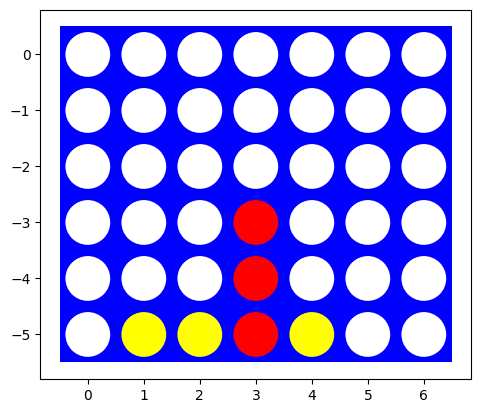

In [2]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

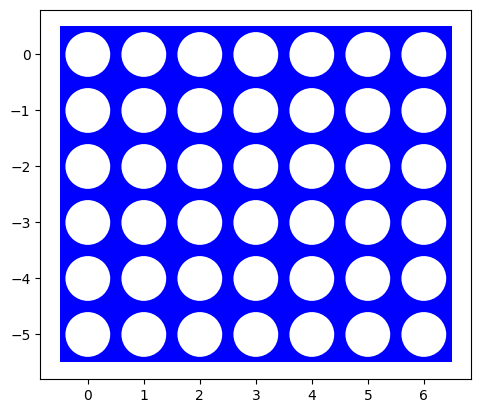

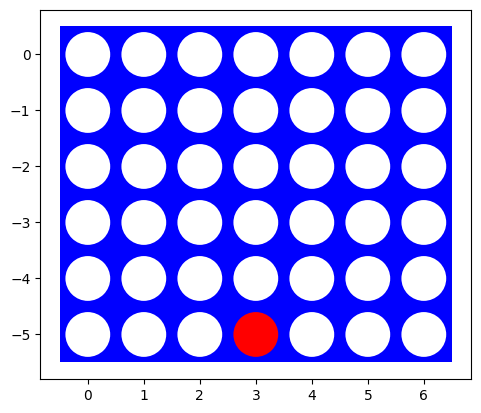

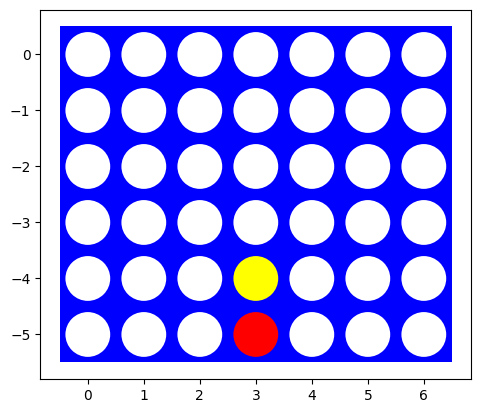

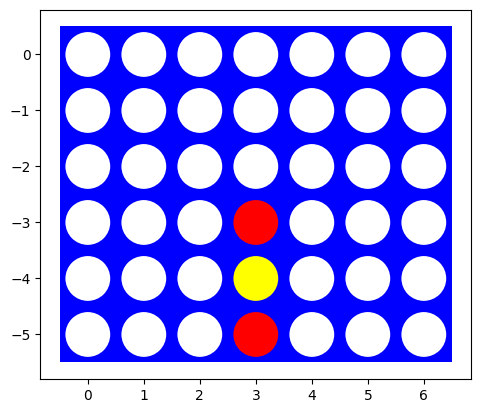

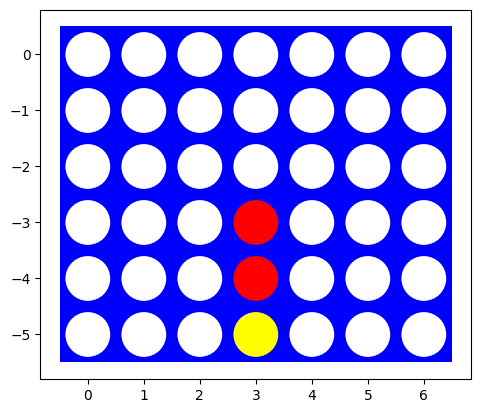

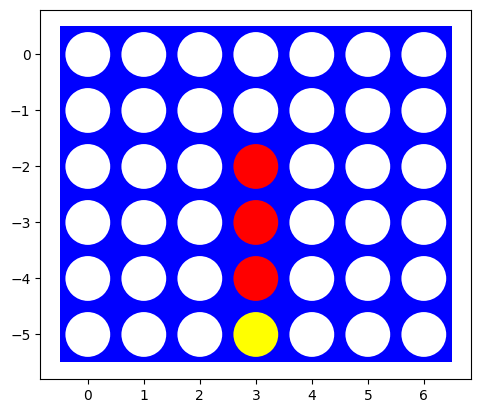

Is terminal? (False, None)
Available actions: [('D', 0), ('D', 1), ('D', 2), ('D', 3), ('D', 4), ('D', 5), ('D', 6)]


In [21]:
import random

# All the available actions
def actions(state, last_mean_move, player):
  available_moves = []
  rows, cols = state.shape

  # Action for Drop moves
  for col in range(cols):
    if state[0, col] == 0:
      available_moves.append(("D", col))

  # Action for Mean moves
  if not last_mean_move:
    for col in range(cols):
      # Ensures its the opponent's piece
      if state[-1, col] == -player:
        available_moves.append(("M", col))

  return available_moves

# Transition model: Apply a move and return a new board state
def result(state, action, player):
  new_state = state.copy()
  move_type, col = action

  # The drop move
  if move_type == 'D':
    for row in range(len(state) - 1, -1, -1):
      # Ensures that its an empty cell
      if new_state[row, col] == 0:
        new_state[row,col] = player
        break

  # The mean move
  elif move_type == "M":
    if new_state[-1, col] == 0 or new_state[-1, col] == player:  # Prevent invalid mean moves
        return new_state  # Return unchanged board

    bottom_piece = new_state[-1, col]  # Save opponent's bottom piece
    new_state[1:, col] = new_state[:-1, col]  # Shift all pieces down
    new_state[0, col] = 0  # Clear the topmost position

    # Drop the opponent's piece to the lowest available row
    for row in range(len(state) - 1, -1, -1):
        if new_state[row, col] == 0:  # Find the first empty spot
            new_state[row, col] = bottom_piece
            break

  return new_state

# Checks if the state is of the game is over or not
def terminal(state):
  rows, cols = state.shape

  def check_win(player):
    # Checks Horizontal
    for r in range(rows):
      for c in range(cols - 3):
        if np.all(state[r,c:c + 4] == player):
          return True

    # Checks Vertical
    for r in range(rows - 3):
      for c in range(cols):
        if np.all(state[r:r+4, c] == player):
          return True

    # Checks diagnols
    for r in range(rows - 3):
      for c in range(cols - 3):
          if np.all(np.array([state[r + i, c + i] == player for i in range(4)])):
              return True
          if np.all(np.array([state[r + 3 - i, c + i] == player for i in range(4)])):
              return True
    return False

  # Tie
  if check_win(1) and check_win(-1):
      return True, 0

  # Player 1 wins
  elif check_win(1):
      return True, 1

  # Player 2 wins
  elif check_win(-1):
      return True, -1

  # If the Board is full
  if np.all(state != 0):
      return True, 0

  return False, None # Game is still going

# Return the results of the game, depending on which player won
def utility(state):
  is_terminal, winner = terminal(state)
  if is_terminal:
        if winner == 1:
            return 10000  # If player 1 wins
        elif winner == -1:
            return -10000  # If player 2 wins
        else:
            return 0  # Tie
  return 0

# Test to see if the functions work
board = empty_board()
visualize(board)

board = result(board, ('D',3), 1)  # Player 1 drops a disc in column 3
visualize(board)
board = result(board, ('D',3), -1)  # Player 2 drops a disc in column 3
visualize(board)
board = result(board, ('D',3), 1)  # Player 1 performs a mean move in column 3
visualize(board)
board = result(board, ('M',3), -1)  # Player 1 performs a mean move in column 3
visualize(board)
board = result(board, ('D',3), 1)  # Player 1 performs a mean move in column 3
visualize(board)

# Check if the game is terminal
print("Is terminal?", terminal(board))

# Get available actions for Player 2
print("Available actions:", actions(board, last_mean_move=True, player=-1))


Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [4]:
def random_player(state, player=None, last_mean_move=False):
    possible_moves = actions(state, last_mean_move, player)
    if not possible_moves:
        return None
    return random.choice(possible_moves)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [ ]:
"""
The 1st player won the most, since they have slight natural advantage, they are making the first move
so the first player will have a slight edge in structuring their moves. However, since they are both
playing randomly, the difference is not going to be extreme. There are also very few ties because of
the mean moves that will prevent frequent drawn games. The results were expected because all the moves
are random and the first player will have the advatange because it is going first.
"""
def simulate_games(num_games=1000):
    results = {1: 0, -1: 0, 0: 0}  # Win counts for Player 1, Player -1, and ties

    for _ in range(num_games):
        board = empty_board()
        player = 1  # Start with player 1
        last_mean_move = False

        while True:
            move = random_player(board, player, last_mean_move)
            if move is None:
                results[0] += 1
                break

            new_board = result(board, move, player)
            if new_board is None:
                results[0] += 1
                break

            board = new_board
            last_mean_move = move[0] == "M"

            # Check if the game is over
            is_terminal, winner = terminal(board)
            if is_terminal:
                results[winner] += 1
                break

            player *= -1  # Switch players

    return results

# Run the simulation again with the fixed code
num_games = 1000
game_results = simulate_games(num_games)

# Display the results
game_results

{1: 600, -1: 374, 0: 26}

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [22]:
import numpy as np
import math

# This is the agent that will use the minimax
def minimax_agent(state, player=1, depth=3):
    # Used for player 1 and obtains the max value
    def max_value(state, alpha, beta, depth):
        # Return the utility if the game ended or the depth reaches zero
        if terminal(state)[0] or depth == 0:
            return utility(state), None

        value = -math.inf
        best_action = None

        # Loops through all the available actions
        for action in ordered_actions(state, last_mean_move=False, player=1):
            new_state = result(state, action, 1)
            new_value, _ = min_value(new_state, alpha, beta, depth - 1)

            # Reassign values depending on the new value
            if new_value > value:
                value = new_value
                best_action = action

            if value >= beta:
                return value, best_action
            # use max for alpha
            alpha = max(alpha, value)

        return value, best_action

    # Used for min value and usually used for the opponent
    def min_value(state, alpha, beta, depth):
        # Return the utility if the game ended or the depth reaches zero
        if terminal(state)[0] or depth == 0:
            return utility(state), None

        value = math.inf
        best_action = None

        # Loops through all the available actions
        for action in ordered_actions(state, last_mean_move=False, player=-1):
            new_state = result(state, action, -1)
            new_value, _ = max_value(new_state, alpha, beta, depth - 1)

            if new_value < value:
                value = new_value
                best_action = action

            if value <= alpha:
                return value, best_action

            beta = min(beta, value)

        return value, best_action

    # Depending on the player, it will decide whether to use the max or the min function
    if player == 1:
        _, action = max_value(state, -math.inf, math.inf, depth)
    else:
        _, action = min_value(state, -math.inf, math.inf, depth)

    return action

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Test Board 1:


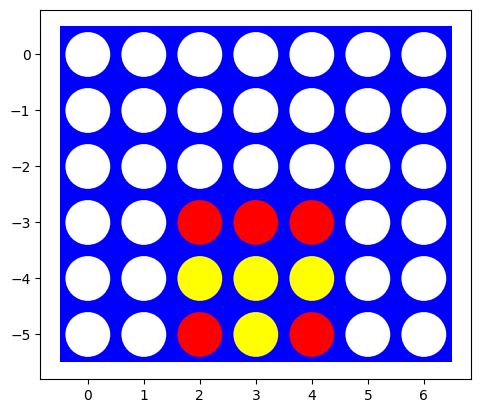

Best Move: ('D', 3)

Test Board 2:


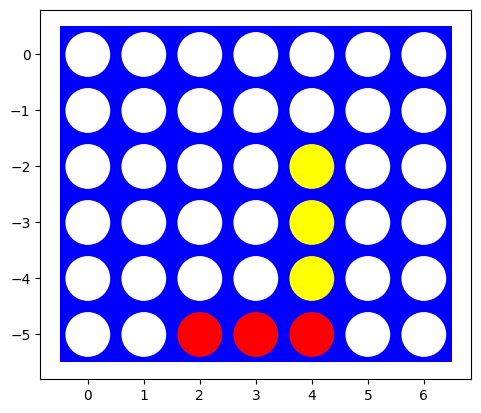

Best Move: ('D', 1)

Test Board 3:


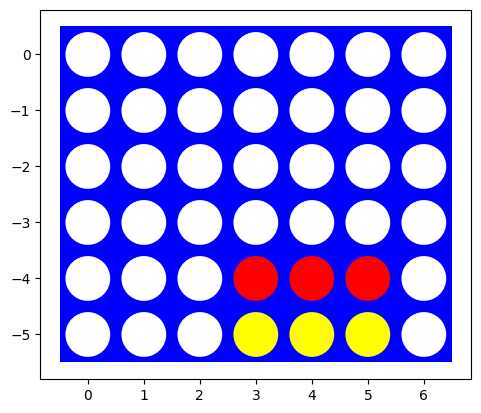

Best Move: ('M', 3)

Test Board 4:


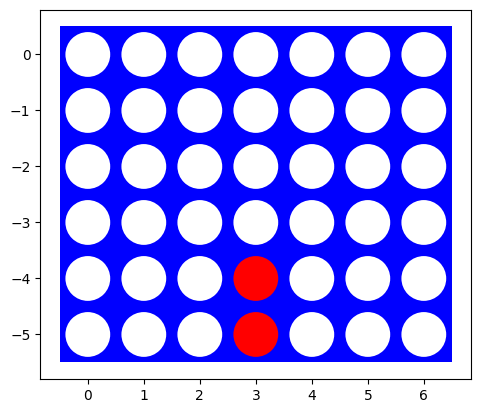

Best Move: ('D', 3)

Test Board 5:


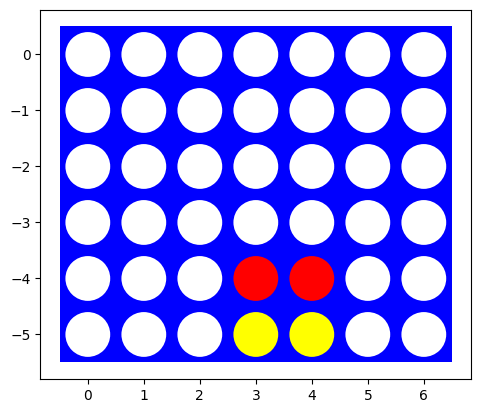

Best Move: ('D', 3)



In [23]:
test_boards = [
    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 1, 1, 0, 0],
              [0, 0,-1,-1,-1, 0, 0],
              [0, 0, 1,-1, 1, 0, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, -1, 0, 0],
              [0, 0, 0, 0, -1, 0, 0],
              [0, 0, 0, 0, -1, 0, 0],
              [0, 0, 1, 1, 1, 0, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0,-1,-1,-1, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0,-1,-1, 0, 0]])
]

for i, board in enumerate(test_boards):
    print(f"Test Board {i+1}:")
    visualize(board)
    move = minimax_agent(board, player=1)
    print(f"Best Move: {move}\n")

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [46]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Function to measure move time
def measure_move_time(board, player=1, depth=4):
    start_time = time.time()
    move = minimax_agent(board, player=player, depth=depth)
    end_time = time.time()
    return end_time - start_time

# Define board sizes (6 rows, varying columns)
board_sizes = [(6, 4), (6, 5), (6, 6), (6, 7)]

# Measure move time for each board size
move_times = []
for rows, cols in board_sizes:
    board = empty_board(shape=(rows, cols))
    time_taken = measure_move_time(board, player=1, depth=4)
    move_times.append(time_taken)
    print(f"Board size: {rows}x{cols}, Time taken: {time_taken:.4f} seconds")

Board size: 6x4, Time taken: 0.0528 seconds
Board size: 6x5, Time taken: 0.1222 seconds
Board size: 6x6, Time taken: 0.2189 seconds
Board size: 6x7, Time taken: 0.3526 seconds


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

In [24]:
import timeit

# Prioritize center columns
def prioritize_center_moves(moves, board):
    center_columns = [len(board[0]) // 2, len(board[0]) // 2 + 1]  # Center columns
    center_moves = [move for move in moves if move[1] in center_columns]
    other_moves = [move for move in moves if move not in center_moves]
    return center_moves + other_moves

# Prioritize odd columns
def prioritize_odd_columns(moves, board):
    odd_columns = [i for i in range(len(board[0])) if i % 2 != 0]  # Odd columns
    odd_moves = [move for move in moves if move[1] in odd_columns]
    other_moves = [move for move in moves if move not in odd_moves]
    return odd_moves + other_moves

# Prioritize center and edge columns
def prioritize_center_and_edges_moves(moves, board):
    center_columns = [len(board[0]) // 2, len(board[0]) // 2 + 1]  # Center columns
    edge_columns = [0, 1, len(board[0]) - 1, len(board[0]) - 2]  # Edge columns
    center_moves = [move for move in moves if move[1] in center_columns]
    edge_moves = [move for move in moves if move[1] in edge_columns]
    other_moves = [move for move in moves if move not in center_moves and move not in edge_moves]
    return center_moves + edge_moves + other_moves

# Prioritize blocking opponent's winning moves
def prioritize_blocking_moves(moves, board, player):
    prioritized_moves = []

    for move in moves:
        new_state = result(board, move, player)
        is_terminal, winner = terminal(new_state)
        if is_terminal and winner == -player:  # Opponent wins in the next move
            prioritized_moves.insert(0, move)  # Blocking move is prioritized
        else:
            prioritized_moves.append(move)  # Non-blocking move

    return prioritized_moves

# Default move ordering (no prioritization)
def default_ordering(moves, board):
    return moves

def ordered_actions(state, last_mean_move, player):
    valid_moves = actions(state, last_mean_move, player)
    # Prioritize center columns
    center_cols = [3, 2, 4, 1, 5, 0, 6]  # Order of preference for columns
    ordered_moves = sorted(valid_moves, key=lambda x: center_cols.index(x[1]))
    return ordered_moves

board = np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0,-1,-1, 0, 0]])

def measure_time(ordering_function, board, player=1, depth=4):
    def run_agent():
        valid_moves = actions(board, last_mean_move=False, player=player)
        ordered_moves = ordering_function(valid_moves, board)
        return minimax_agent(board, player=player, depth=depth)

    return timeit.timeit(run_agent, number=1)

ordering_strategies = [
    ("Default Ordering", default_ordering),
    ("Prioritize Center Moves", prioritize_center_moves),
    ("Prioritize Odd Columns", prioritize_odd_columns),
    ("Prioritize Center and Edges", prioritize_center_and_edges_moves),
    ("Prioritize Blocking Moves", lambda moves, board: prioritize_blocking_moves(moves, board, player=1))
]

times = []
for strategy_name, strategy_function in ordering_strategies:
    time_taken = measure_time(strategy_function, board)
    times.append((strategy_name, time_taken))

# Print the results as a table
print("Move Ordering Strategy | Time Taken (seconds)")
print("--------------------------------------------")
for strategy_name, time_taken in times:
    print(f"{strategy_name:25} | {time_taken:.6f}")

Move Ordering Strategy | Time Taken (seconds)
--------------------------------------------
Default Ordering          | 0.507889
Prioritize Center Moves   | 0.489159
Prioritize Odd Columns    | 0.498916
Prioritize Center and Edges | 0.494479
Prioritize Blocking Moves | 0.563113


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

Turn 1, Player 1 action: ('D', 3)


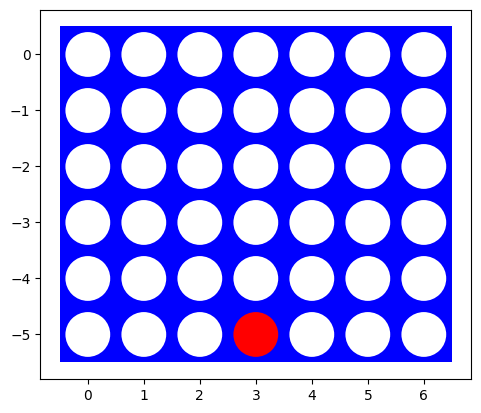

Turn 2, Player -1 action: ('D', 3)


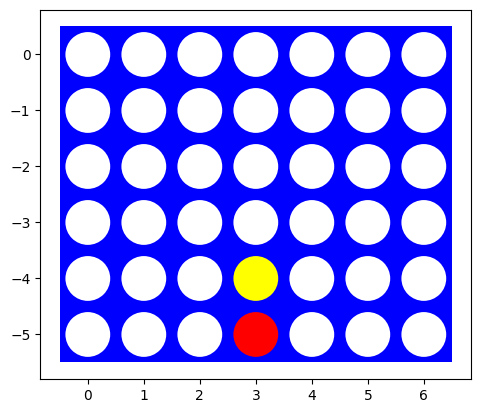

Turn 3, Player 1 action: ('D', 3)


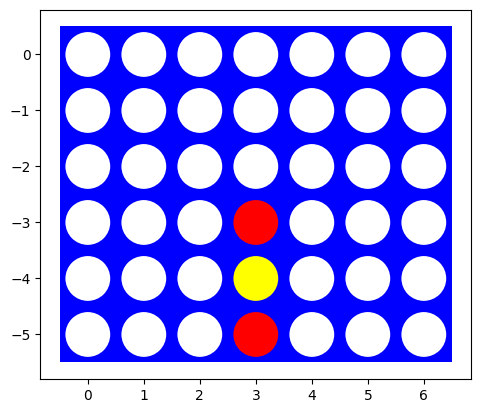

Turn 4, Player -1 action: ('D', 3)


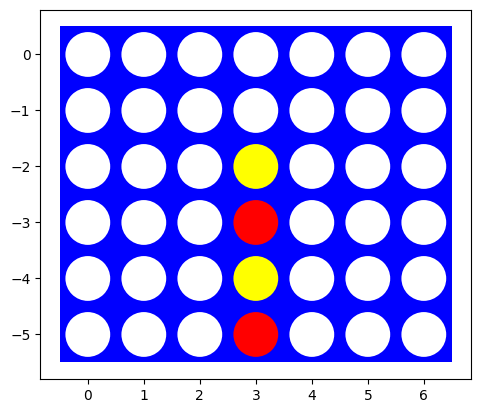

Turn 5, Player 1 action: ('D', 3)


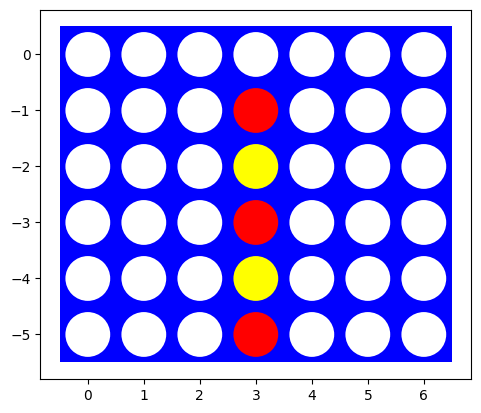

Turn 6, Player -1 action: ('D', 3)


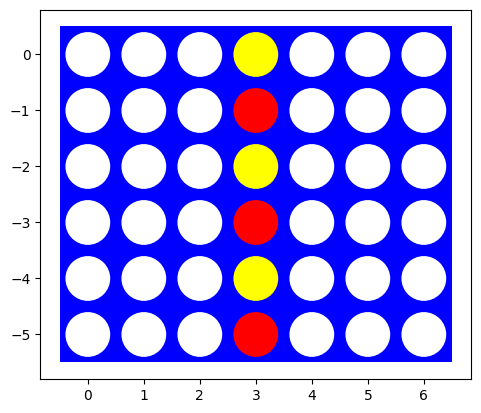

Turn 7, Player 1 action: ('D', 2)


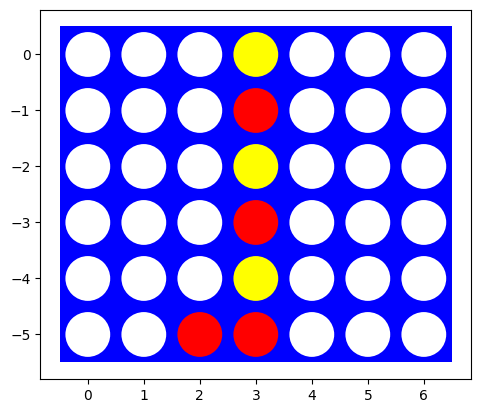

Turn 8, Player -1 action: ('M', 3)


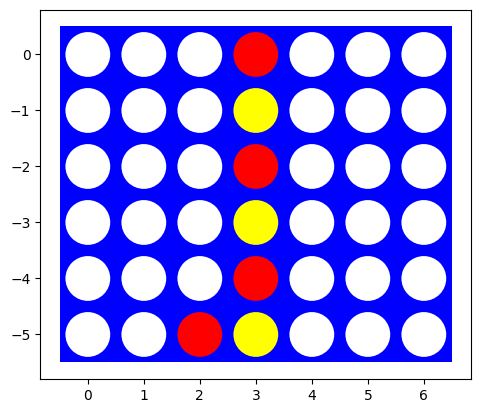

Turn 9, Player 1 action: ('M', 3)


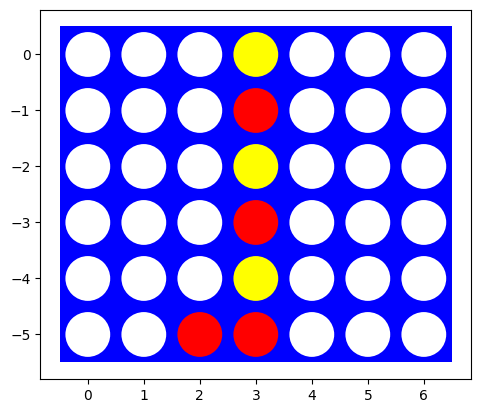

Turn 10, Player -1 action: ('M', 3)


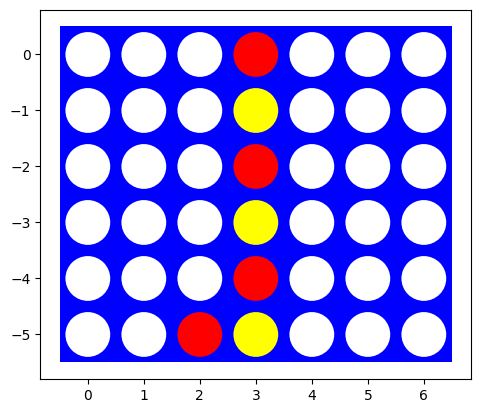

In [25]:
board = empty_board()

# Simulate the first few moves
for turn_number in range(10):  # Simulate 10 turns
    player = 1 if turn_number % 2 == 0 else -1
    move = minimax_agent(board, player=player, depth=4)
    if move is None:
        print("No valid moves left. Game over.")
        break

    # Apply the move to the board
    board = result(board, move, player)

    # Visualize the board
    print(f"Turn {turn_number + 1}, Player {player} action: {move}")
    visualize(board)

    # Check if the game is over
    is_terminal, winner = terminal(board)
    if is_terminal:
        if winner == 0:
            print("Tie")
        else:
            print(f"Player {winner} wins")
        break

# Answer:
As mentioned before if you start with an empty board it causes the minimax algorithm with alpha beta pruning to run into the worst case scenario. This is because it has to take account of all possible moves before making a move and there are also no immediate winning or losing moves, so Alpha-Beta pruning cannot effectively reduce the search space.

Some ways to optimize is by implementing heuristics or any other form of optimizations to improve our search efficiency. A simple heurisitic will help guide the first few moves instead of solely relying on the minimax, and it will avoid the need for the minimax algorithm to explore the entire game tree.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [8]:
def play_minimax_vs_random(num_games=10):
  results =  {1:0, -1:0, 0:0}

  for _ in range(num_games):
      board = empty_board(shape=(4, 4))
      player = 1  # Minimax starts first
      last_mean_move = False

      while True:
          if player == 1:
              move = minimax_agent(board, depth=4, player=player)
          else:
              move = random_player(board, player, last_mean_move)

          if move is None:
              break  # No valid moves

          board = result(board, move, player)
          last_mean_move = move[0] == "M"
          is_terminal, winner = terminal(board)

          if is_terminal:
              results[winner] += 1
              break

          player *= -1  # Switch players

  return results

num_games = 10
game_results = play_minimax_vs_random(num_games)

# Display the results
game_results

{1: 10, -1: 0, 0: 0}

# Analysis:
You can see that the minimax agent won the most because it finds the best move out of all possible avialable moves. Unlike the random agent where it randomly chooses a move disregarding whether it is the best move or not.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [47]:
"""
The heuristic function should evaluate a board position without having to search for the terminal states, it
should assign high scores for winning or near winning positions, and penalize opponent's for their strong
positions. There should also be board control and for my implementation I decided to put more control on
the center of the board.
"""
def heuristic_evaluation(state, player):
    rows, cols = state.shape
    score = 0

    # Helper function to evaluate sequences
    def evaluate_sequence(seq, player):
        player_count = np.count_nonzero(seq == player)
        empty_count = np.count_nonzero(seq == 0)
        opponent_count = np.count_nonzero(seq == -player)

        # Winning sequence for the player
        if player_count == 4:
            return 1000
        # Almost winning for the player
        elif player_count == 3 and empty_count == 1:
            return 100
        # Potential for the player
        elif player_count == 2 and empty_count == 2:
            return 10
        # Opponent is about to win
        elif opponent_count == 3 and empty_count == 1:
            return -200
        # Opponent has won
        elif opponent_count == 4:
            return -1000
        # Opponent has potential
        elif opponent_count == 2 and empty_count == 2:
            return -10
        return 0

    # Evaluate rows
    for r in range(rows):
        for c in range(cols - 3):
            score += evaluate_sequence(state[r, c:c + 4], player)

    # Evaluate columns
    for r in range(rows - 3):
        for c in range(cols):
            score += evaluate_sequence(state[r:r + 4, c], player)

    # Evaluate diagonals (top-left to bottom-right)
    for r in range(rows - 3):
        for c in range(cols - 3):
            score += evaluate_sequence(np.array([state[r + i, c + i] for i in range(4)]), player)

    # Evaluate diagonals (bottom-left to top-right)
    for r in range(3, rows):
        for c in range(cols - 3):
            score += evaluate_sequence(np.array([state[r - i, c + i] for i in range(4)]), player)

    # Center control
    center_col = cols // 2
    center_weight = 5  # Higher weight for the center column
    adjacent_weight = 2  # Lower weight for adjacent columns

    # Score for the center column
    score += np.count_nonzero(state[:, center_col] == player) * center_weight

    # Score for adjacent columns
    if center_col - 1 >= 0:
        score += np.count_nonzero(state[:, center_col - 1] == player) * adjacent_weight
    if center_col + 1 < cols:
        score += np.count_nonzero(state[:, center_col + 1] == player) * adjacent_weight

    return score

### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [48]:
# The modified minimax search where you can imput a cutoff search for the depth, and uses the heuristic function
def minimax_with_cutoff(state, depth, alpha, beta, maximizing_player, player, last_mean_move):
    is_terminal, winner = terminal(state)
    # Use utility function for terminal states
    if is_terminal:
        return utility(state), None

    # Use heuristic for non-terminal states
    if depth == 0:
        return heuristic_evaluation(state, player), None

    valid_moves = actions(state, last_mean_move, player)

    if maximizing_player:
        max_eval = -float("inf")
        best_move = None
        for move in valid_moves:
            new_state = result(state, move, player)
            eval_value, _ = minimax_with_cutoff(new_state, depth - 1, alpha, beta, False, -player, move[0] == 'M')

            if eval_value > max_eval:
                max_eval = eval_value
                best_move = move
            alpha = max(alpha, eval_value)

            if beta <= alpha:
                break
        return max_eval, best_move
    else:
        min_eval = float("inf")
        best_move = None
        for move in valid_moves:
            new_state = result(state, move, player)
            eval_value, _ = minimax_with_cutoff(new_state, depth - 1, alpha, beta, True, -player, move[0] == "M")

            if eval_value < min_eval:
                min_eval = eval_value
                best_move = move
            beta = min(beta, eval_value)

            if beta <= alpha:
                break
        return min_eval, best_move

# The agent that is using the minimax algorithm
def heuristic_minimax_agent(state, player=1, depth=4, last_mean_move=False):
    valid_moves = actions(state, last_mean_move, player)
    best_move = None
    best_value = -float("inf") if player == 1 else float("inf")

    for move in valid_moves:
        new_state = result(state, move, player)
        eval_value, _ = minimax_with_cutoff(new_state, depth - 1, -float("inf"), float("inf"), False, -player, move[0] == "M")

        if player == 1 and eval_value > best_value:
            best_value = eval_value
            best_move = move

        elif player == -1 and eval_value < best_value:
            best_value = eval_value
            best_move = move

    return best_move

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

Test Board 1:


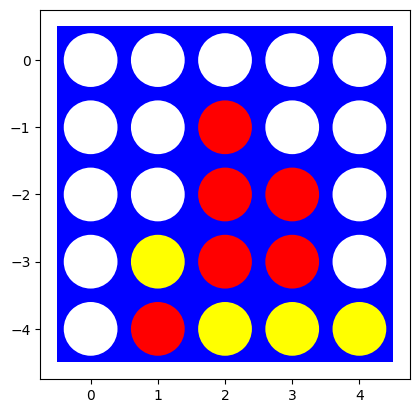

Best Move: ('D', 2)

Test Board 2:


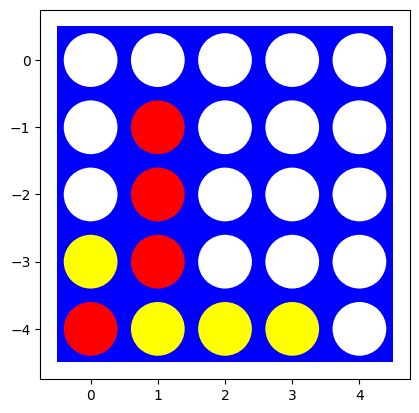

Best Move: ('D', 1)

Test Board 3:


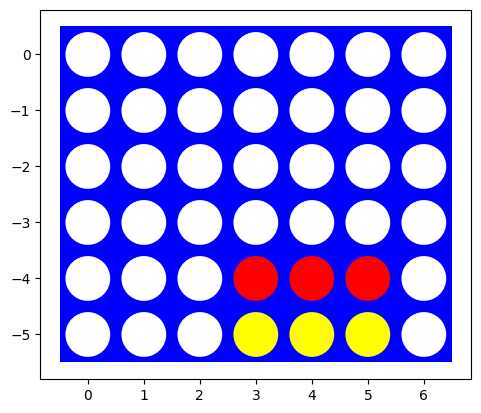

Best Move: ('M', 3)

Test Board 4:


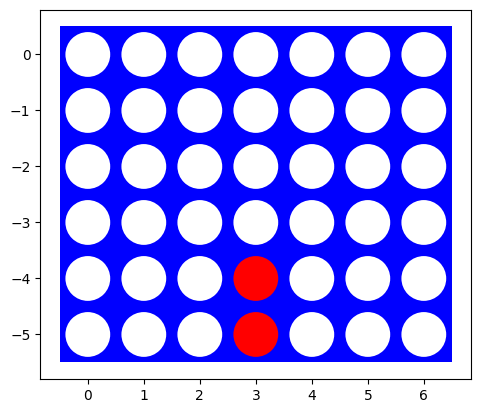

Best Move: ('D', 2)

Test Board 5:


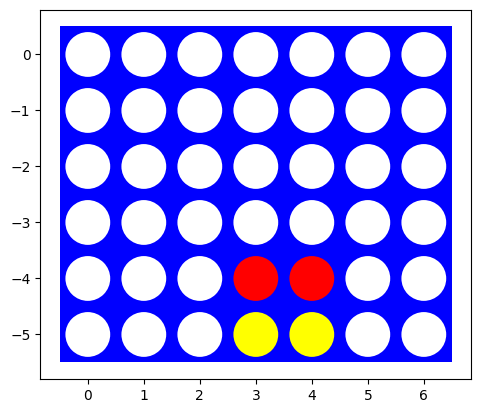

Best Move: ('D', 5)



In [43]:
# Testing on different board states
test_boards = [
    np.array([[0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 1, 1, 0],
              [0, -1, 1, 1, 0],
              [0, 1,-1,-1,-1]]),

    np.array([[0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 1, 0, 0, 0],
              [-1, 1, 0, 0, 0],
              [1,-1,-1,-1, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0,-1,-1,-1, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0]]),

    np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0,-1,-1, 0, 0]])
]

for i, board in enumerate(test_boards):
    print(f"Test Board {i+1}:")
    visualize(board)
    move = heuristic_minimax_agent(board, player=1, depth=4, last_mean_move=False)
    print(f"Best Move: {move}\n")

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [44]:
import pandas as pd
import time

board_sizes = [4, 5, 6, 7]
depths = [2, 3, 4, 5]

timing_results_cutoff = {}

for cols in board_sizes:
    for depth in depths:
        test_board = empty_board(shape=(6, cols))
        start_time = time.time()
        heuristic_minimax_agent(test_board, player=1, depth=depth, last_mean_move=False)
        end_time = time.time()

        timing_results_cutoff[(cols, depth)] = end_time - start_time

df = pd.DataFrame.from_dict(timing_results_cutoff, orient="index", columns=["Time (s)"])
df.index = pd.MultiIndex.from_tuples(df.index, names=["Columns", "Depth"])
df

Time (s)
Columns Depth           
4       2       0.013444
        3       0.052851
        4       0.195163
        5       0.589777
5       2       0.030074
        3       0.108112
        4       0.575901
        5       1.793597
6       2       0.056096
        3       0.225961
        4       1.921639
        5       5.166096
7       2       0.094045
        3       0.382823
        4       2.690414
        5      10.175374

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [50]:
def heuristic_vs_heuristic(depth1, depth2):
  board = empty_board(shape=(6,7))
  player = 1
  last_mean_move = False

  while True:
    if player == 1:
      move = heuristic_minimax_agent(board, player=1, depth=depth1, last_mean_move=last_mean_move)
    else:
      move = heuristic_minimax_agent(board, player=-1, depth=depth2, last_mean_move=last_mean_move)

    # If there are no moves then stop the game
    if move is None:
      break
    # New board
    board = result(board, move, player)
    last_mean_move = move[0] == "M"
    is_terminal, winner = terminal(board)

    # Once the game ends then you return the winner of the game
    if is_terminal:
      return winner

    player *= -1

winner = heuristic_vs_heuristic(4, 3)
print(f"Heuristic Agent 1 (depth 4) vs Heuristic Agent 2 (depth 3) -> Winner: {'Agent 1' if winner == 1 else 'Agent 2' if winner == -1 else 'Tie'}")

Heuristic Agent 1 (depth 4) vs Heuristic Agent 2 (depth 3) -> Winner: Agent 1


---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
